In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from scipy.ndimage.measurements import label
%matplotlib inline

## HOG features

In [33]:
from skimage.feature import hog

TRAINING_DATA_IMAGE_SIZE = 64 # size of images for hog training data
ORIENTATIONS = 9
PIXEL_PER_CELL = 8
CELL_PER_BLOCK = 2

def get_hog_features(img, visualise=False):
    """hog features of a square image.
    
    This function does the following steps:
    - convert to grayscale if not already
    - resize if necessary
    - compute hog
    """
    
    # grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # resize
    if gray.shape != (TRAINING_DATA_IMAGE_SIZE, TRAINING_DATA_IMAGE_SIZE):
        gray = cv2.resize(gray, (TRAINING_DATA_IMAGE_SIZE, TRAINING_DATA_IMAGE_SIZE)) 
    return hog(gray,
        orientations=ORIENTATIONS,
        pixels_per_cell=(PIXEL_PER_CELL, PIXEL_PER_CELL),
        cells_per_block=(CELL_PER_BLOCK, CELL_PER_BLOCK),
        visualise=visualise, feature_vector=True)

In [3]:
def get_hog_features_whole_image(gray):
    """
    faster hog feature computation for actual prediction pipeline. Compute hog feature on whole image
    (not scaled to the requires size of (TRAINING_DATA_IMAGE_SIZE, TRAINING_DATA_IMAGE_SIZE)). 
    
    input: a gray image of any scale
    
    """
    return hog(gray,
        orientations=ORIENTATIONS,
        pixels_per_cell=(PIXEL_PER_CELL, PIXEL_PER_CELL),
        cells_per_block=(CELL_PER_BLOCK, CELL_PER_BLOCK),
        visualise=False, feature_vector=False)

### HOG feature visualization

/Users/lilijiang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


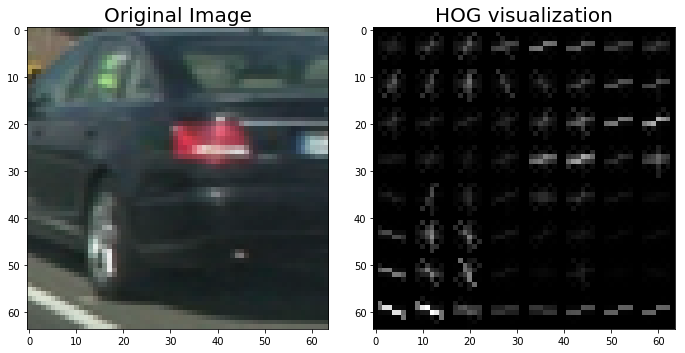

HOG feature shape (1764,)


In [37]:
test_image_path = 'dataset/vehicles/GTI_Right/image0000.png'
img = mpimg.imread(test_image_path)
features, hog_img = get_hog_features(img, visualise=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hog_img, cmap='gray')
ax2.set_title('HOG visualization', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

print('HOG feature shape', features.shape)

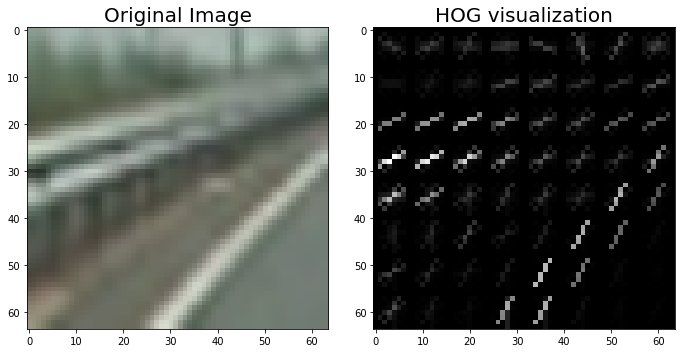

HOG feature shape (1764,)


In [23]:
test_image_path = 'dataset/non-vehicles/GTI/image8.png'
img = mpimg.imread(test_image_path)
features, hog_img = get_hog_features(img, visualise=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(hog_img, cmap='gray')
ax2.set_title('HOG visualization', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

print('HOG feature shape', features.shape)

## Color histogram

In [51]:
BINS = 32

In [65]:
def get_color_histogram(img):
    """color histogram features of a square image.
    
    This function does the following steps:
    - resize if necessary
    - compute color histogram
    """
    
    # resize
    if img.shape != (TRAINING_DATA_IMAGE_SIZE, TRAINING_DATA_IMAGE_SIZE, 3):
        img = cv2.resize(img, (TRAINING_DATA_IMAGE_SIZE, TRAINING_DATA_IMAGE_SIZE))
    
    if img.max() > 1:
        img = img / 255
        
    red_histogram = np.histogram(img[:,:,0], bins=BINS, range=(0, 1))
    green_histogram = np.histogram(img[:,:,1], bins=BINS, range=(0, 1))
    blue_histogram = np.histogram(img[:,:,2], bins=BINS, range=(0, 1))
    return np.concatenate((red_histogram[0], green_histogram[0], blue_histogram[0]))

## Load data and compute features

data source: http://www.gti.ssr.upm.es/~jal/download.html

In [70]:
POSITIVE_DATA_DIR = 'dataset/vehicles'
NEGATIVE_DATA_DIR = 'dataset/non-vehicles'

In [71]:
positive_data_path = []
negative_data_path = []

for root, dirs, files in os.walk(POSITIVE_DATA_DIR):
    for file in files:
        if file.endswith(".png"):
             positive_data_path.append(os.path.join(root, file))
                
for root, dirs, files in os.walk(NEGATIVE_DATA_DIR):
    for file in files:
        if file.endswith(".png"):
             negative_data_path.append(os.path.join(root, file))

In [72]:
print('number of positive data:', len(positive_data_path))
print('number of negative data:', len(negative_data_path))

number of positive data: 8792
number of negative data: 8968


In [73]:
# label
y = [1 for i in range(len(positive_data_path))] + [0 for i in range(len(negative_data_path))]

In [77]:
# feature vectors
hog_features = [get_hog_features(mpimg.imread(path), visualise=False) for path in positive_data_path + negative_data_path] 

In [81]:
color_features = [get_color_histogram(mpimg.imread(path)) for path in positive_data_path + negative_data_path] 

In [83]:
# scale
from sklearn.preprocessing import StandardScaler

hog_feature_scaler = StandardScaler().fit(hog_features)
scaled_hog_features = hog_feature_scaler.transform(hog_features)

color_feature_scaler = StandardScaler().fit(color_features)
scaled_color_features = color_feature_scaler.transform(color_features)

In [84]:
# # save the Scaler
# with open(r"hog_feature_scaler.pkl", "wb") as f:
#     pickle.dump(hog_feature_scaler, f)
# with open(r"color_feature_scaler.pkl", "wb") as f:
#     pickle.dump(color_feature_scaler, f)

In [4]:
with open(r"hog_feature_scaler.pkl", "rb") as f:
    hog_feature_scaler = pickle.load(f)
with open(r"color_feature_scaler.pkl", "rb") as f:
    color_feature_scaler = pickle.load(f)

In [90]:
X = [np.concatenate((hog, color)) for hog, color in zip(scaled_hog_features, scaled_color_features)]

In [91]:
# split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## SVM classifier

In [5]:
from sklearn.svm import SVC

In [92]:
clf = SVC(max_iter=-1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('accuracy on training set', train_score)
print('accuracy on test set', test_score)

accuracy on training set 0.999562062062
accuracy on test set 0.989864864865


In [125]:
## save the trained svm classifier
with open(r"clf_with_color_features.pkl", "wb") as f:
    pickle.dump(clf, f)

In [126]:
with open(r"clf_with_color_features.pkl", "rb") as f:
    clf = pickle.load(f)

### qualitative evaluation of svm classifier

test svm on images cropped from the video

In [97]:
def svm_demo(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    hog_features = get_hog_features(img)
    scaled_hog_features = hog_feature_scaler.transform([list(hog_features)])
    color_features = get_color_histogram(img)
    scaled_color_features = color_feature_scaler.transform([list(color_features)])
    feature = np.concatenate((hog_features, color_features))
    prediction = clf.predict(feature)[0]
    if prediction == 1:
        plt.title('prediction: car')
    else:
        plt.title('prediction: not car')

/Users/lilijiang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


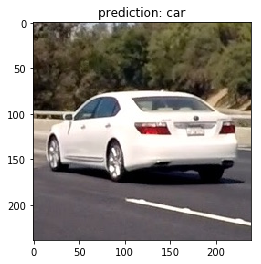

In [44]:
svm_demo('test_images_cropped/test4.jpg')

/Users/lilijiang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


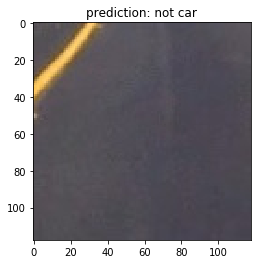

In [45]:
svm_demo('test_images_cropped/test2.jpg')

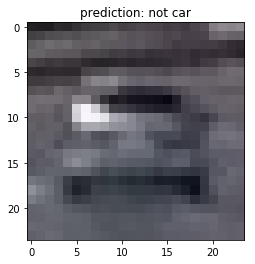

In [99]:
svm_demo('test_images_cropped/test7.jpg')

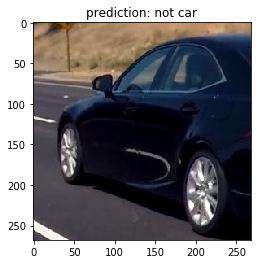

In [98]:
svm_demo('test_images_cropped/test8.jpg')

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



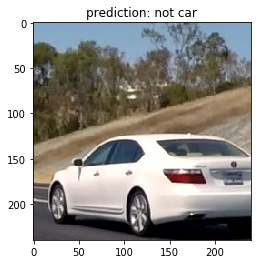

In [544]:
svm_demo('test_images_cropped/frame227.jpg')

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



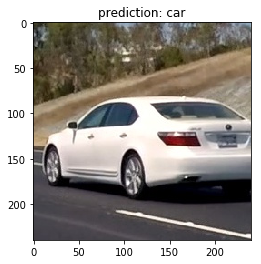

In [545]:
svm_demo('test_images_cropped/frame227a.jpg')

## sliding window search

In [7]:
from collections import namedtuple
# size: int, pixels per size
# x_stride: int, how many cells to move over till the next window in the x direction
# y_max: float, the lowest (on image) point to search with this box size, in ratio (range from 0 to 1)
SearchWindow = namedtuple("SearchWindow", "size x_stride, y_stride y_min y_max")

In [8]:
search_windows = [
    SearchWindow(160, 1, 1, 0.2, 0.9),
    SearchWindow(120, 1, 3, 0.2, 0.8),
    SearchWindow(80, 1, 1, 0.3, 0.6),
    ]

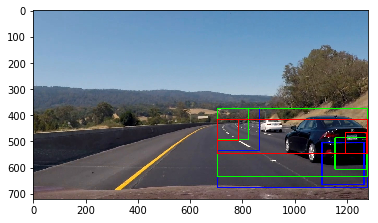

In [48]:
image = mpimg.imread('project_video_subclip_frames/frame115.jpg')
height, width = image.shape[:2]
y_cutoff_min = int(height * 0.4)
new_height = height - y_cutoff_min
x_cutoff_min = int(width * 0.55)
new_width = width - x_cutoff_min
image_copy = np.copy(image)
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0)]

for i, w in enumerate(search_windows):
    (x0, y0) = (x_cutoff_min, y_cutoff_min + int(new_height * w.y_min))
    cv2.rectangle(image_copy, (x0, y0), (x0 + w.size, y0 + w.size), colors[i], thickness=3)
    cv2.rectangle(image_copy, (x0, y0), (width, y_cutoff_min + int(new_height * w.y_max)), colors[i], thickness=3)
    (x1, y1) = (width - new_width % int(w.size / (TRAINING_DATA_IMAGE_SIZE / PIXEL_PER_CELL) * w.x_stride),
                y_cutoff_min + int(new_height * w.y_max) - new_height % int(w.size / PIXEL_PER_CELL * w.y_stride))
    cv2.rectangle(image_copy, (x1 - w.size, y1 - w.size), (x1, y1), colors[i], thickness=3)

plt.imshow(image_copy)

In [9]:
def is_in_omitted_area(box, omitted_area):
    """return True if the box does not overlap with any of the omitted area."""
    if omitted_area:
        for omitted_box in omitted_area:
            separated = (box[0][0] >= omitted_box[1][0]) or (box[1][0] <= omitted_box[0][0]) \
                        or (box[0][1] >= omitted_box[1][1]) or (box[1][1] <= box[0][1])
            if not separated:
                return True
    return False

In [3]:
SEARCH_Y_MIN_OF_HEIGHT = 0.4  # start searching only from 0.4 * image height onwards
SEARCH_X_MIN_OF_WIDTH = 0.55
VIDEO_FRAME_HEIGHT = 720
VIDEO_FRAME_WIDTH = 1280
Y_CUTOFF_MIN = int(VIDEO_FRAME_HEIGHT * SEARCH_Y_MIN_OF_HEIGHT)
X_CUTOFF_MIN = int(VIDEO_FRAME_WIDTH * SEARCH_X_MIN_OF_WIDTH)
CROPPED_HEIGHT = VIDEO_FRAME_HEIGHT - Y_CUTOFF_MIN
CROPPED_WIDTH = VIDEO_FRAME_WIDTH - X_CUTOFF_MIN

In [4]:
def crop_to_area_of_interest(image):
    return image[Y_CUTOFF_MIN : VIDEO_FRAME_HEIGHT, X_CUTOFF_MIN : VIDEO_FRAME_WIDTH]

In [114]:
def search_and_classify(image, omitted_area=None, search_omitted_area_only=False, draw=True):
    """ slide windows over the image and use SVM to classify each patch's HOG feature.
    
    omitted_area: a box already identified by nearest neighbour method. Don't search in that area.
        format: [((x0, y0), (x1, y1)),], which are the coordinates for the upper left and lower right corners
        of the boxes
    search_omitted_area: default to false which is to omit to area when searching. When set, search only in this
        area. This is useful for merging.
    """
    
    # crop to only have lower right corner of the image
    cropped_image = crop_to_area_of_interest(image)
    
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY) 
    image_copy = np.copy(image)
    box_list = []
    
    for window in search_windows:
        scale = TRAINING_DATA_IMAGE_SIZE / window.size
        nblocks_per_window = (TRAINING_DATA_IMAGE_SIZE // PIXEL_PER_CELL) - CELL_PER_BLOCK + 1
        # resize. For example if the search window size is 128x128, and the hog feature requires 64x64 size
        # then scale such that a 128 pixels in the original image is 64 pixels in the scaled image
        scaled_gray = cv2.resize(gray, (int(CROPPED_WIDTH * scale), int(CROPPED_HEIGHT * scale)))
        whole_image_hog_feature = get_hog_features_whole_image(scaled_gray)
        hog_height, hog_width = whole_image_hog_feature.shape[:2]
        
        for y in range(int(window.y_min * hog_height),
                       int(window.y_max * hog_height - nblocks_per_window),
                       window.y_stride): 
            for x in range(0, int(hog_width - nblocks_per_window), window.x_stride):
                # coordinates of upper left corner and lower right corners on the original uncropped image
                (x0, y0) = (int(x * PIXEL_PER_CELL / scale) + X_CUTOFF_MIN,
                            int(y * PIXEL_PER_CELL / scale) + Y_CUTOFF_MIN)
                box = [(x0, y0), (x0 + window.size, y0 + window.size)]
                
                # if not to search in omitted area only,
                # classify only if the box does not overlap with already identified area
                # if search in omitted area only, only search if the boxes overlap with the omitted area
                if search_omitted_area_only == is_in_omitted_area(box, omitted_area):
                    hog_feature = whole_image_hog_feature[
                        y : y + nblocks_per_window, x : x + nblocks_per_window].ravel()
                    scaled_hog_feature = hog_feature_scaler.transform([list(hog_feature)])
                    color_feature = get_color_histogram(image[y0 : y0 + window.size, x0 : x0 + window.size])
                    scaled_color_feature = color_feature_scaler.transform([list(color_feature)])
                    feature = list((np.concatenate((scaled_hog_feature[0], scaled_color_feature[0]))))
                    if clf.predict(feature)[0] == 1:
                        box_list.append(box)
                        if draw:
                            cv2.rectangle(image_copy, box[0], box[1], (0, 255, 0), thickness=3)
    
    if draw:
        f, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.imshow(image_copy)
        plt.show()

    return box_list

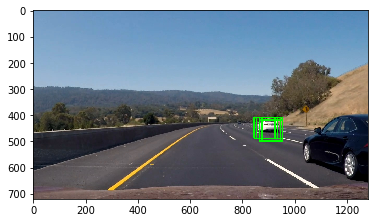

In [115]:
image = mpimg.imread('test_images/test8.jpg')
_ = search_and_classify(image)

In [117]:
import time

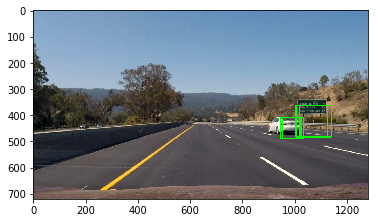

4.802308082580566


In [118]:
start = time.time()
image = mpimg.imread('project_video_frames/frame478.jpg')
_ = search_and_classify(image, omitted_area = [((864, 408), (944, 488))])
print(time.time() - start)

## heat map

In [13]:
def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

In [14]:
def create_heatmap_from_boxlist(img, box_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, box_list)
    return heatmap

In [15]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    heatmap = np.clip(heatmap, 0, 255)
    return heatmap

In [16]:
# a long box with short width is an unlikely candidate for a car
MINIMAL_WIDTH_TO_HEIGHT_RATIO = 1/2  # qualifying bounding box has to minimally have this ratio

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    box_list = []
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if (bbox[1][0] - bbox[0][0]) / (bbox[1][1] - bbox[0][1]) > MINIMAL_WIDTH_TO_HEIGHT_RATIO:
            box_list.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, box_list

In [17]:
def vehicle_detection_from_box_list(img, box_list, threshold, show_heatmap=True):
    heatmap = create_heatmap_from_boxlist(img, box_list)
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    draw_img, final_box_list = draw_labeled_bboxes(np.copy(img), labels)
    if show_heatmap:
        fig = plt.figure(figsize=(12, 9))
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    return draw_img, final_box_list

In [119]:
PER_FRAME_HEATMAP_THRESHOLD = 4

def box_car_from_frame(frame, debug=False):
    boxlist = search_and_classify(frame, draw=debug)
    img, final_boxlist = vehicle_detection_from_box_list(frame, boxlist, PER_FRAME_HEATMAP_THRESHOLD, show_heatmap=debug)
    if debug:
        f, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.imshow(img)
        plt.show()
    return img, final_boxlist

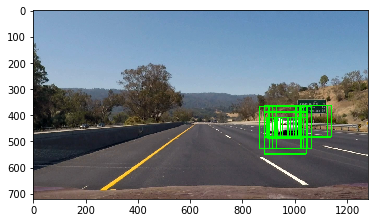

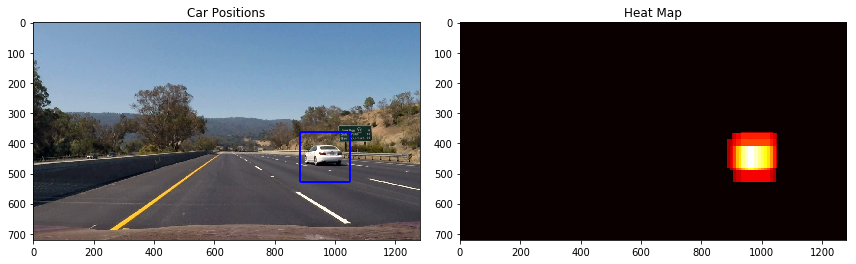

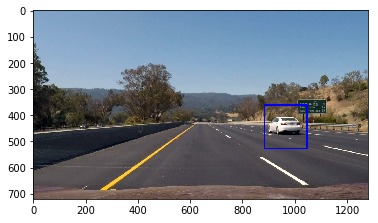

In [120]:
_ = box_car_from_frame(mpimg.imread('project_video_frames/frame478.jpg'), debug=True)

## nearest neighbor matching

given a box of previously identified vehicle, search in the next frame in the vicinity and locate the car

In [19]:
BINARY_THRESHOLD = 100
BLUR_DEGREE = 3

def get_saturation_binary_image(image):
    saturation_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)[:, :, 2]
    saturation_binary = np.zeros_like(saturation_channel)
    saturation_binary[saturation_channel >= BINARY_THRESHOLD] = 1
    return saturation_binary

def identify_car_patch(saturation_binary):
    """identify the biggest consecutive saturated patch as the car area."""
    # blur the image by moving right 3 steps and down steps and overlap the images
    # blur because sometimes a patch for car area can be disconnected by just a few pixels
    binary_blur = np.copy(saturation_binary)
    for i in range(1, BLUR_DEGREE):
        binary_blur[i:, :] += saturation_binary[:-i, :]
        binary_blur[:, i:] += saturation_binary[:, :-i]
    binary_blur = np.clip(binary_blur, 0, 1)
    labels = label(binary_blur)
    
    # find the biggest consecutive car patch
    max_count = 0
    car_patch = -1
    for i in range(1, labels[1]):
        count = np.array(labels[0] == i).sum()
        if count > max_count:
            car_patch = i
            max_count = count

    car_area_binary = np.zeros_like(saturation_binary)
    car_area_binary[(saturation_binary == 1) & (labels[0] == car_patch)] = 1
    return car_area_binary
        

In [20]:
VICINITY = 30  # search within this many pixels from previously identified area
PERCENTAGE_OVERLAP_THRESHOLD = 0.5
NEAREST_NEIGHBOUR_STRIDE = 2

def pixel_matching(current_frame, previous_box_list, match_patches, previous_frame=None, draw=False):
    """ find the nearest neighbor patch in the current frame below some minimal distance
    
    match_patches: list of image patches to be matched. should be output from the classifier
    
    """
    current_box_list = []
    matched_patches = []  # which frame is being matched
    height, width = current_frame.shape[:2]
    for i in range(len(previous_box_list)):
        box = previous_box_list[i]
        match_patch = match_patches[i]
        (x0, y0), (x1, y1) = box
        previous_saturation_binary = get_saturation_binary_image(match_patch)
        previous_car_area_binary = identify_car_patch(previous_saturation_binary)
         
        max_percentage = 0
        new_car_box = None
        
        for x in range(max(0, x0 - VICINITY), min(x0 + VICINITY, width - x1 + x0), NEAREST_NEIGHBOUR_STRIDE):
            for y in range(max(0, y0 - VICINITY), min(y0 + VICINITY, height - y1 + y0), NEAREST_NEIGHBOUR_STRIDE):
                area = current_frame[y :  y + y1 - y0, x : x + x1 - x0]
                current_saturation_binary = get_saturation_binary_image(area)
                # percentage of previously saturated area that is saturated in the current frame
                common_area = np.array(current_saturation_binary[previous_car_area_binary==1] == 1).sum()
                percentage = common_area / previous_car_area_binary.sum()
                if percentage > PERCENTAGE_OVERLAP_THRESHOLD and percentage > max_percentage:
                    current_car_area_binary = identify_car_patch(current_saturation_binary)
                    # percentage of current saturated area that is saturated in the previous frame
                    percentage2 = common_area / current_car_area_binary.sum()
                    if percentage2 > PERCENTAGE_OVERLAP_THRESHOLD and percentage > max_percentage:
                        new_car_box = ((x, y), (x + x1 - x0, y + y1 - y0))
                        max_percentage = percentage
                        min_saturation_binary = current_saturation_binary

        if new_car_box is not None:
            current_box_list.append(new_car_box)
            matched_patches.append(match_patch)
        
    if draw:
        print('max_percentage', max_percentage)
        print('old box', box)
        print('new_box', new_car_box)
        fig, ax = plt.subplots(3, 2, figsize=(12, 9))
        ax[0, 0].imshow(previous_saturation_binary, cmap='gray')
        ax[0, 0].title.set_text('previous frame saturation binary')
        ax[0, 1].imshow(min_saturation_binary, cmap='gray')
        ax[0, 1].title.set_text('current frame saturation binary')
        difference = np.zeros_like(previous_car_area_binary) - 1
        difference[previous_car_area_binary==1] = 0
        difference[(min_saturation_binary == 1) & (previous_car_area_binary==1)] = 1
        ax[1, 0].imshow(difference, cmap='hot')
        ax[1, 0].title.set_text('differences')
        overlay = np.zeros_like(area)
        overlay[previous_car_area_binary==1] = (0, 0, 255)
        ax[1, 1].imshow(overlay, alpha=0.5)
        overlay = np.zeros_like(area)
        overlay[min_saturation_binary==1] = (255, 0, 0)
        ax[1, 1].imshow(overlay, alpha=0.3)
        ax[1, 1].title.set_text('overlay')

        for box in previous_box_list:
            if box is not None:
                cv2.rectangle(previous_frame, box[0],box[1], (0, 0, 255), 6)
        ax[2, 0].imshow(previous_frame)
        ax[2, 0].title.set_text('previous frame')

        for box in current_box_list:
            if box is not None:
                cv2.rectangle(current_frame, box[0],box[1], (0, 0, 255), 6)
        ax[2, 1].imshow(current_frame)
        ax[2, 1].title.set_text('current frame')

        fig.show()
            
    return current_box_list, matched_patches

In [21]:
def pixel_matching_demo(previous_frame, current_frame):
    raw_boxlist = search_and_classify(previous_frame, draw=False)
    previous_frame_boxed, previous_box_list = vehicle_detection_from_box_list(
        previous_frame, raw_boxlist, PER_FRAME_HEATMAP_THRESHOLD, show_heatmap=False)
    match_patches = []
    for box in previous_box_list:
        (x0, y0), (x1, y1) = box
        match_patches.append(previous_frame[y0 : y1, x0 : x1])
    current_box_list, matched_frames = pixel_matching(current_frame, previous_box_list, match_patches, previous_frame, draw=True)

max_percentage 0.876534296029
old box ((884, 363), (1003, 497))
new_box ((884, 367), (1003, 501))


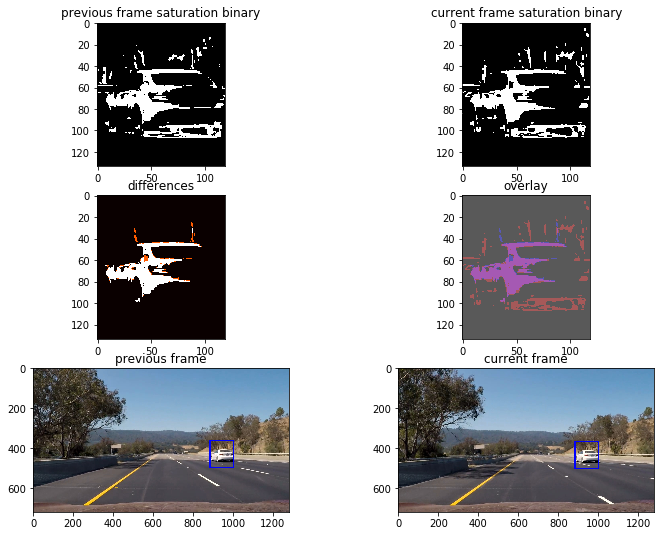

In [128]:
pixel_matching_demo(
    mpimg.imread('project_video_frames/frame524.jpg'),
    mpimg.imread('project_video_frames/frame529.jpg'),
    )

## pipeline for video

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
SKIP_FRAMES = 5 # only analyze 1 in 5 frames

In [5]:
IMAGE_DIFFERENTIATION_THRESHOLD = 3 * (10 ** 7)
def is_substantially_different(image1, image2):
    """ determine if two frames, after cropping, are substantially different to warrant new search."""
    image1 = crop_to_area_of_interest(image1)
    image2 = crop_to_area_of_interest(image2)
    if np.array((image1 - image2) ** 2).sum() > IMAGE_DIFFERENTIATION_THRESHOLD:
        return True
    return False

46005686


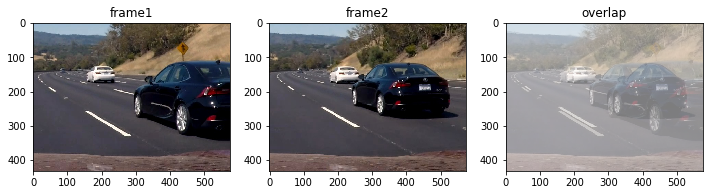

In [16]:
# is substantially different demo:

frame1 = crop_to_area_of_interest(mpimg.imread('project_video_frames/frame720.jpg'))
frame2 = crop_to_area_of_interest(mpimg.imread('project_video_frames/frame755.jpg'))
print(np.array((frame1 - frame2) ** 2).sum())

fig, ax = plt.subplots(1, 3, figsize=(12, 9))
ax[0].imshow(frame1)
ax[0].title.set_text('frame1')
ax[1].imshow(frame2)
ax[1].title.set_text('frame2')
ax[2].imshow(frame1, alpha=0.3)
ax[2].imshow(frame2, alpha=0.3)
ax[2].title.set_text('overlap')
plt.show()

In [25]:
def get_patches_from_boxlist(image, boxlist):
    patches = []
    for box in boxlist:
        (x0, y0), (x1, y1) = box
        patches.append(image[y0 : y1, x0 : x1])
    return patches

In [121]:
def process_video_frame(frame):
    """ given a frame from video and output a frame with boxes around vehicles.
    
    - Classify only every other 5 frames.
        The subsequent 4 frames directly copy the result from the last classified frame.
    - Go through the SVM classifier if satisfying any of the condition:
        a) first frame or previous frame does not have identified car yet
        b) OR current frame is substantially different from the last classified frame
        c) OR nearest neighbour method returns fewer identified vehicles then the previous frame
        * in condition b) and c), we will do a limited search,
          avoiding the vehicles already identified from nearest neighbour
        ** if new vehicles are identified in the limited search, then re-search the omitted area for
          for possible merges (a newly classified area could just be another part of the same car from the
          nearest neighbor search)
    - Otherwise, use nearest neighbor search to save classification time
    
    """
    global frame_count
    global last_box_list
    global last_frame
    global last_classified_frame  # the last frame that runs svm on. to compare how much current frame has differed
    global last_classified_patches # patches to match for nearest neighbour search
    
    return_image = np.copy(frame)
    if frame_count % SKIP_FRAMES != 0:
        # copy results from previous frame
        for box in last_box_list:
            cv2.rectangle(return_image, box[0], box[1], (0, 0, 255), 6)
        new_box_list = last_box_list
    else:
        if len(last_box_list) == 0:
            # fully classify
            raw_box_list = search_and_classify(frame, draw=False)
            return_image, new_box_list = vehicle_detection_from_box_list(
                frame, raw_box_list, PER_FRAME_HEATMAP_THRESHOLD, show_heatmap=False)
            last_classified_frame = np.copy(frame)
            last_classified_patches = get_patches_from_boxlist(frame, new_box_list)

        else:
            # nearest_neighbor
            nearest_neighbor_box_list, last_classified_patches =\
                pixel_matching(frame, last_box_list, last_classified_patches)
            new_box_list = nearest_neighbor_box_list[:]
             # draw the boxes from nearest neighbor search
            for box in nearest_neighbor_box_list:
                cv2.rectangle(return_image, box[0], box[1], (0, 0, 255), 6)
                    
            if is_substantially_different(frame, last_classified_frame)\
                or len(nearest_neighbor_box_list) < len(last_box_list):
                # in addition, classify with omitted area
                raw_box_list = search_and_classify(frame, omitted_area=nearest_neighbor_box_list, draw=False)
                return_image, svm_box_list = vehicle_detection_from_box_list(
                    frame, raw_box_list, PER_FRAME_HEATMAP_THRESHOLD,
                     show_heatmap=False)
                for box in nearest_neighbor_box_list:
                    cv2.rectangle(return_image, box[0], box[1], (0, 0, 255), 6)
                
                # merge with existing patches if apply
                if len(svm_box_list) > 0:
                    omitted_area_raw_box_list = search_and_classify(
                        frame, omitted_area=nearest_neighbor_box_list, search_omitted_area_only=True, draw=False)
                    return_image, new_box_list = vehicle_detection_from_box_list(
                        frame, raw_box_list + omitted_area_raw_box_list, PER_FRAME_HEATMAP_THRESHOLD,
                         show_heatmap=False)
                    
                    last_classified_patches = get_patches_from_boxlist(frame, new_box_list)
                    
                last_classified_frame = np.copy(frame)
    
    # update global variable
    frame_count += 1
    last_box_list = new_box_list
    last_frame = frame
    
    return return_image

In [122]:
output_filename = 'project_video_output_final.mp4'

In [123]:
video = VideoFileClip("project_video.mp4")
frame_count = 0
last_box_list = []
last_frame = None
last_classified_frame = None
last_classified_patches = []
output = video.fl_image(process_video_frame)
%time output.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video project_video_output_final.mp4
[MoviePy] Writing video project_video_output_final.mp4


100%|█████████▉| 1260/1261 [14:05<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_final.mp4 

CPU times: user 12min 9s, sys: 26.1 s, total: 12min 36s
Wall time: 14min 7s


In [127]:
HTML("""
<video width="960" he\ight="540" controls>
  <source src="{0}">
</video>
""".format(output_filename))